Adaptado de ["Classificação de Imagens"](https://www.tensorflow.org/tutorials/images/classification?hl=pt-br) dos [tutoriais do Tensorflow](https://www.tensorflow.org/tutorials/).

# Classificação de Imagens

Este tutorial mostra como classificar imagens de flores usando um modelo `tf.keras.Sequential` e carregar dados usando `tf.keras.utils.image_dataset_from_directory`. Ele demonstra os seguintes conceitos:


* Carregamento eficiente de um conjunto de dados do disco.
* Identificação de sobreajuste e aplicação de técnicas para atenuá-lo, incluindo aumento e eliminação de dados.

Este tutorial segue um fluxo de trabalho básico de aprendizado de máquina:

1. Examinar e entender os dados
2. Criar um pipeline de entrada
3. Criar o modelo
4. Treinar o modelo
5. Testar o modelo
6. Aprimore o modelo e repita o processo

## Configuração

Importe o TensorFlow e outras bibliotecas necessárias:

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Faça o download e explore o conjunto de dados

Este tutorial usa um conjunto de dados com cerca de 3.700 fotos de flores. O conjunto de dados contém cinco subdiretórios, um por classe:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [42]:
import requests
import tarfile
import os
import pathlib

# Especificar aonde está armazenado o arquivo com as fotos compactadas
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
file_name = "flower_photos.tgz"

# Baixar o arquivo compactado com as imagens do conjuntos de dados
response = requests.get(url, stream=True)
with open(file_name, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

print(f"Download concluído: {file_name}")

# 2. Extrair o arquivo .tgz
extract_path = os.getcwd()+'/datasets'
with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall(path=extract_path)

data_dir = pathlib.Path(extract_path+'/'+file_name.split('.')[0]).with_suffix('')
print(f"Arquivos extraídos em: {data_dir}")


Download concluído: flower_photos.tgz
Arquivos extraídos em: /workspace/computer-vision/datasets/flower_photos


Após o download, você deverá ter uma cópia do conjunto de dados disponível. Há um total de 3.670 imagens:

In [43]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Aqui estão algumas rosas:

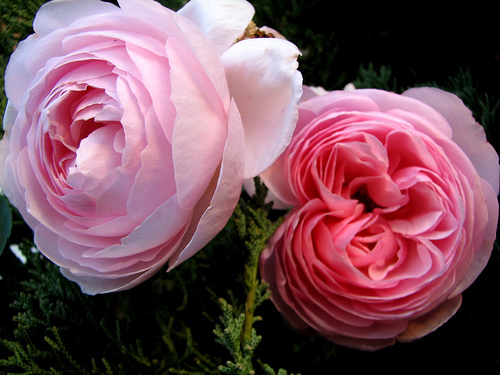

In [44]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

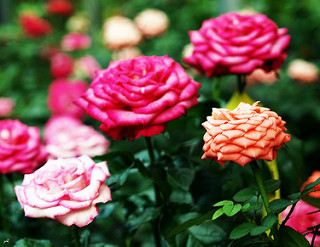

In [45]:
PIL.Image.open(str(roses[1]))

E algumas tulipas:

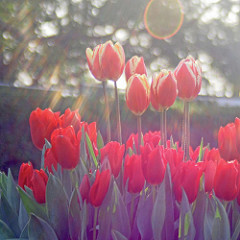

In [46]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

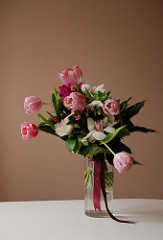

In [47]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Carregar dados usando um utilitário do Keras

Em seguida, carregue essas imagens usando o utilitário `tf.keras.utils.image_dataset_from_directory`.

Isso o levará de um diretório de imagens no disco para um `tf.data.Dataset` em apenas algumas linhas de código.

### Crie o conjunto de dados(_dataset_)

Defina alguns parâmetros para o carregador:

In [48]:
batch_size = 32
img_height = 180
img_width = 180

É uma boa prática usar uma divisão de validação ao desenvolver seu modelo. Use 80% das imagens para treinamento e 20% para validação.

In [49]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


I0000 00:00:1725994493.932948   11349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725994493.950517   11349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725994493.953526   11349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725994493.956878   11349 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [50]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Você pode encontrar os nomes das classes no atributo `class_names` nesses conjuntos de dados. Eles correspondem aos nomes dos diretórios em ordem alfabética.

In [51]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize os dados

Aqui estão as primeiras nove imagens do conjunto de dados de treinamento:

2024-09-10 18:55:58.103265: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


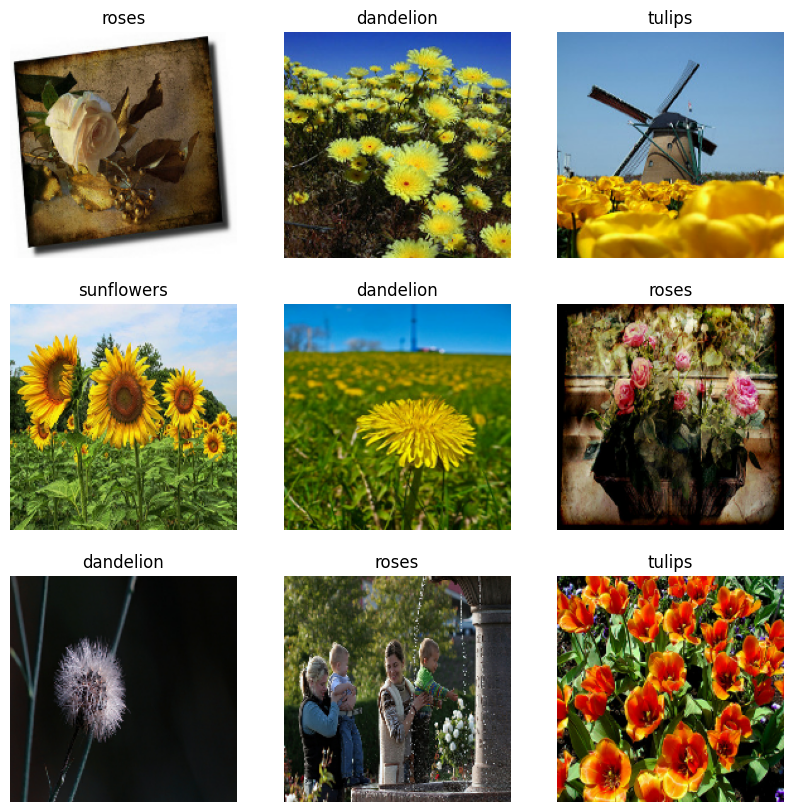

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Você passará esses conjuntos de dados para o método `Model.fit` do Keras para treinamento mais adiante neste tutorial.

Se desejar, você também pode iterar manualmente o conjunto de dados e recuperar lotes de imagens:

In [53]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


O `image_batch` é um tensor com a forma `(32, 180, 180, 3)`.
- Trata-se de um lote de 32 imagens de formato `180x180x3` (a última dimensão refere-se aos canais de cores RGB).
- O `label_batch` é um tensor da forma `(32,)`, esses são os rótulos correspondentes às 32 imagens.

Você pode chamar `.numpy()` nos tensores `image_batch` e `labels_batch` para convertê-los em um `numpy.ndarray`.

## Configure o conjunto de dados para desempenho

Certifique-se de usar o pré-busca com buffer(_buffered prefetching_), para que você possa obter dados do disco sem que a E/S se torne bloqueada. Esses são dois métodos importantes que você deve usar ao carregar dados:

- O `Dataset.cache` mantém as imagens na memória depois que elas são carregadas do disco durante a primeira época. Isso garantirá que o conjunto de dados não se torne um gargalo durante o treinamento do modelo. Se o conjunto de dados for muito grande para caber na memória, você também poderá usar esse método para criar um cache de alto desempenho no disco.
- O `Dataset.prefetch` sobrepõe o pré-processamento de dados e a execução do modelo durante o treinamento.

Se estiver interessado, pode saber mais sobre os dois métodos, bem como sobre como armazenar dados em cache no disco, na seção *Prefetching* do guia [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance?hl=pt-br).

In [54]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Padronize os dados

Os valores do canal RGB estão no intervalo `[0, 255]`. Isso não é ideal para uma rede neural; em geral, você deve procurar tornar os valores de entrada pequenos.

Aqui, você padronizará os valores para que fiquem no intervalo `[0, 1]` usando `tf.keras.layers.Rescaling`:

In [55]:
normalization_layer = layers.Rescaling(1./255)

Há duas maneiras de usar essa camada. Você pode aplicá-la ao conjunto de dados chamando `Dataset.map`:

In [56]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Observe que os valores de pixel estão agora em `[0,1]`.
print(np.min(first_image), np.max(first_image))

4.233566e-06 0.9543138


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## Um modelo básico do Keras

### Criar o modelo

O modelo Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) consiste em três blocos de convolução (`tf.keras.layers.Conv2D`) com uma camada de pooling máximo (`tf.keras.layers.MaxPooling2D`) em cada um deles.

Há uma camada totalmente conectada (`tf.keras.layers.Dense`) com 128 unidades na parte superior, que é ativada por uma função de ativação ReLU (`'relu'`).

Esse modelo não foi ajustado para alta acurácia; o objetivo deste tutorial é mostrar uma abordagem padrão.

In [57]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compilar o modelo

Para este tutorial, escolha o otimizador `tf.keras.optimizers.Adam` e a função de perda `tf.keras.losses.SparseCategoricalCrossentropy`.

Para visualizar a acurácia do treinamento e da validação para cada época de treinamento, passe o argumento `metrics` para `Model.compile`.

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Resumo do modelo

Visualize todas as camadas da rede usando o método `Model.summary` do Keras:

In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Treine o modelo

Treine o modelo para 10 épocas com o método `Model.fit` do Keras:

In [60]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1725996080.666681   16168 service.cc:146] XLA service 0x7ae774006bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725996080.666704   16168 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-09-10 19:21:20.685246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 19:21:20.785866: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 1/92 ━━━━━━━━━━━━━━━━━━━━ 6:05 4s/step - accuracy: 0.1250 - loss: 1.6456

I0000 00:00:1725996084.059320   16168 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.3017 - loss: 1.6440 - val_accuracy: 0.5763 - val_loss: 1.0602
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6085 - loss: 1.0115 - val_accuracy: 0.6090 - val_loss: 0.9872
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6654 - loss: 0.8574 - val_accuracy: 0.6240 - val_loss: 0.9216
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7405 - loss: 0.6919 - val_accuracy: 0.6185 - val_loss: 1.0042
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8404 - loss: 0.4730 - val_accuracy: 0.6376 - val_loss: 1.0055
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9163 - loss: 0.2778 - val_accuracy: 0.6526 - val_loss: 1.0719
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9517 - loss: 0.1684 - val_accuracy: 0.6458 - val_loss: 1.4301
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9594 - loss: 0.1310 - val_accuracy: 0.6403 - val_loss: 1

## Visualize os resultados do treinamento

Crie gráficos da perda e da acurácia nos conjuntos de treinamento e validação:

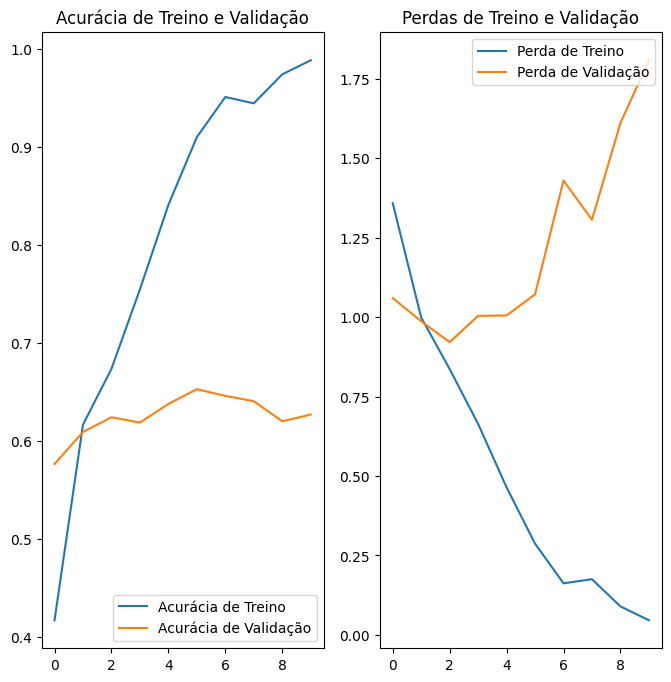

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perdas de Treino e Validação')
plt.show()

Os gráficos mostram que a acurácia do treinamento e a acurácia da validação estão fora de uma grande margem, e o modelo alcançou apenas cerca de 60% de acurácia no conjunto de validação.

As seções do tutorial a seguir mostram como inspecionar o que deu errado e tentar aumentar o desempenho geral do modelo.

## Sobreajuste(_Overfitting_)

Nos gráficos acima, a acurácia do treinamento está aumentando linearmente ao longo do tempo, ao passo que a acurácia da validação fica parada em torno de 60% no processo de treinamento. Além disso, a diferença entre a acurácia do treinamento e da validação é perceptível - um sinal de [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Quando há um pequeno número de exemplos de treinamento, o modelo às vezes aprende com ruídos ou detalhes indesejados dos exemplos de treinamento - a ponto de afetar negativamente o desempenho do modelo em novos exemplos. Esse fenômeno é conhecido como sobreajuste. Isso significa que o modelo terá dificuldade para generalizar em um novo conjunto de dados.

Há várias maneiras de combater o ajuste excessivo no processo de treinamento. Neste tutorial, você usará *data augmentation* e adicionará *dropout* ao seu modelo.

## Aumento de Dados(_Data augmentation_)

O overfitting geralmente ocorre quando há um pequeno número de exemplos de treinamento.

O [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=pt-br) adota a abordagem de gerar dados de treinamento adicionais a partir dos exemplos existentes, aumentando-os com transformações aleatórias que geram imagens de aparência crível. Isso ajuda a expor o modelo a mais aspectos dos dados e a generalizar melhor.

Você implementará o aumento de dados usando as seguintes camadas de pré-processamento do Keras: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation` e `tf.keras.layers.RandomZoom`. Elas podem ser incluídas em seu modelo como outras camadas e executadas na GPU.

In [62]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize alguns exemplos aumentados aplicando o aumento de dados à mesma imagem várias vezes:

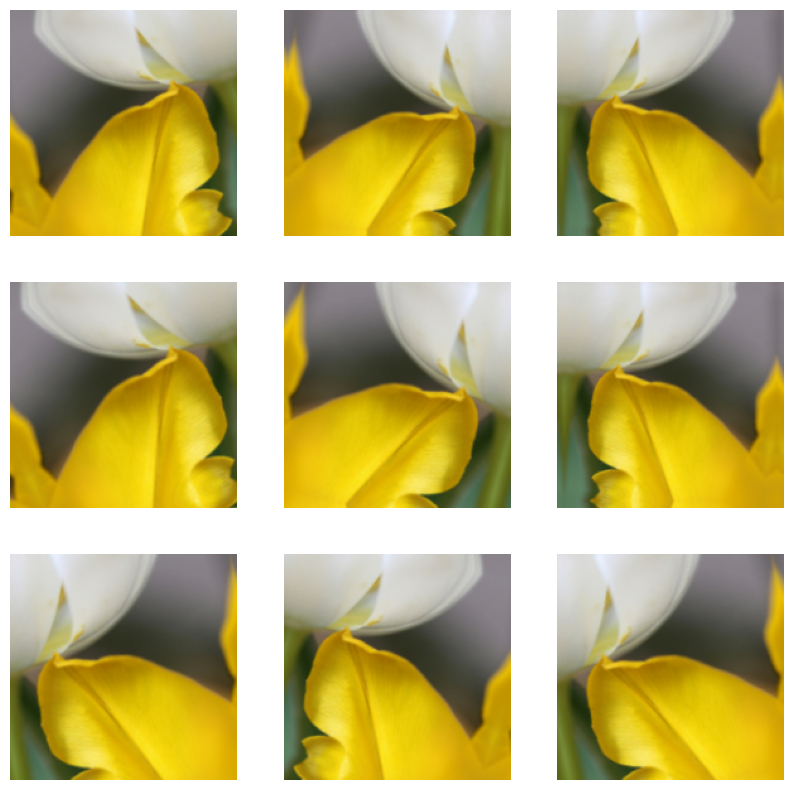

In [65]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Na próxima etapa, você adicionará o aumento de dados ao seu modelo antes do treinamento.

## Dropout

Outra técnica para reduzir o overfitting é introduzir a regularização [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} na rede.

Quando você aplica o dropout a uma camada, ele elimina aleatoriamente (definindo a ativação como zero) um número de unidades de saída da camada durante o processo de treinamento.
- O dropout usa um número fracionário como seu valor de entrada, na forma de 0,1, 0,2, 0,4 etc.
- Isso significa eliminar 10%, 20% ou 40% das unidades de saída aleatoriamente da camada aplicada.

Crie uma nova rede neural com `tf.keras.layers.Dropout` antes de treiná-la usando as imagens aumentadas:

In [66]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile e treine o modelo

In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [69]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2024-09-10 19:32:22.499461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
W0000 00:00:1725996742.803135   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996742.819160   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996742.821091   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996742.822907   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996742.824372   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996742.825889   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement

 1/92 ━━━━━━━━━━━━━━━━━━━━ 4:20 3s/step - accuracy: 0.2500 - loss: 1.6003

W0000 00:00:1725996744.339322   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996744.341408   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996744.347158   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996744.355301   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996744.364563   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996744.370714   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996744.372840   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996744.374965   16165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996744.377480   16165 gp

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3083 - loss: 1.6697

W0000 00:00:1725996745.938419   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996745.940056   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996745.941603   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996745.943117   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996745.944426   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996745.945760   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996745.947093   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996745.949820   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996745.953258   16168 gp

60/92 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3133 - loss: 1.6534

W0000 00:00:1725996747.012349   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996747.014116   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996747.019635   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996747.025320   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996747.033535   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996747.037893   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996747.039719   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996747.041556   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996747.043705   16168 gp

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3436 - loss: 1.5593

W0000 00:00:1725996748.243552   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.245347   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.247047   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.248437   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.250098   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.252332   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.253742   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.256904   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.260078   16168 gp

92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3443 - loss: 1.5571 - val_accuracy: 0.5545 - val_loss: 1.0915
Epoch 2/15


W0000 00:00:1725996748.451568   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.453422   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.454812   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.456256   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.457745   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.459519   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.461089   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.463347   16168 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725996748.465388   16168 gp

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5316 - loss: 1.1399 - val_accuracy: 0.5790 - val_loss: 1.0408
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6139 - loss: 1.0073 - val_accuracy: 0.5722 - val_loss: 1.0119
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6412 - loss: 0.9286 - val_accuracy: 0.6390 - val_loss: 0.8883
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6759 - loss: 0.8490 - val_accuracy: 0.6390 - val_loss: 0.9740
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6795 - loss: 0.8013 - val_accuracy: 0.6798 - val_loss: 0.8412
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7096 - loss: 0.7336 - val_accuracy: 0.6907 - val_loss: 0.7989
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7365 - loss: 0.6720 - val_accuracy: 0.6512 - val_loss: 0.8755
Epoch 9/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7464 - loss: 0.6859 - val_accuracy: 0.7112 - val_loss: 0.

## Visualize os resultados do treinamento

Depois de aplicar o aumento de dados e `tf.keras.layers.Dropout`, há menos overfitting do que antes, e a acurácia do treinamento e da validação estão mais alinhadas:

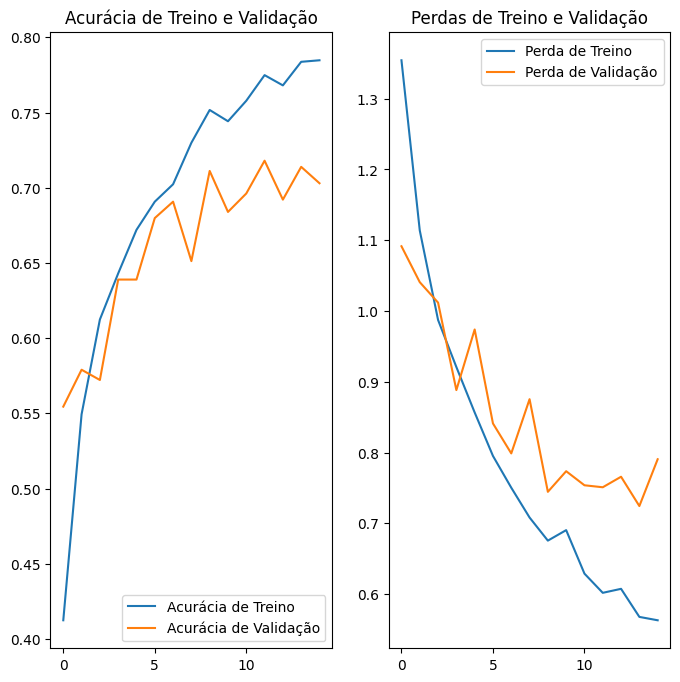

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perdas de Treino e Validação')
plt.show()

## Prever com base em novos dados

Use seu modelo para classificar uma imagem que não foi incluída nos conjuntos de treinamento ou validação.

Observação: As camadas de aumento de dados e de abandono estão inativas no momento da inferência.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Essa imagem provavelmente é uma sunflowers com 99.92 por cento de confiança.


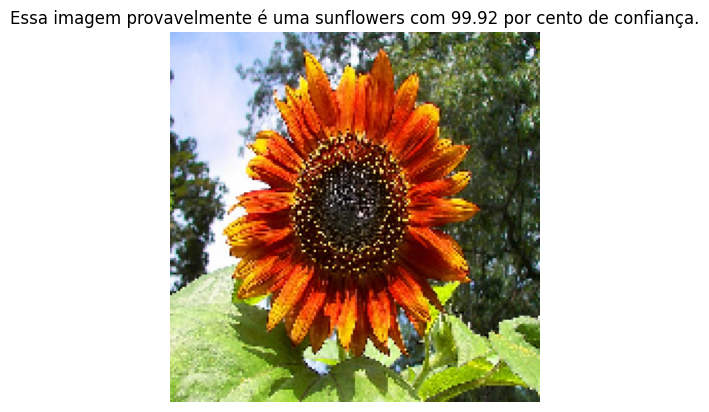

In [73]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Essa imagem provavelmente é uma {} com {:.2f} por cento de confiança."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# Exibe a imagem
# Remove a dimensão do batch para visualização
img_array = np.squeeze(img_array, axis=0)

# Plota a imagem
plt.imshow(img_array.astype('uint8'))
plt.title(
    "Essa imagem provavelmente é uma {} com {:.2f} por cento de confiança."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
plt.axis('off')  # Remove os eixos para melhor visualização
plt.show()